# MLP vs CNN 
### by Pio Lauren T. Mendoza 

This notebook demonstrates the performance difference of a between MLP and CNN with respect to varying hyperparameters.
Different MLP and CNN models will be used to classify the CIFAR10 dataset.

We must first import the necessary modules (i.e. maplotlib.pylot, numpy, and tensorflow)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import inspect
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import cifar10

The machine used for running this notebook has a good gpu. The list of of gpu of the machine can be check by running the method below.

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(f"Number of GPUs: {len(gpus)}")
print("List of GPUs:", *gpus, sep='\n\t-')

Number of GPUs: 1
List of GPUs:
	-PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Loading CIFAR10 Dataset
Data will be loaded from tf.keras.dataset

In [3]:
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()
print("Number of samples for training: ", xTrain.shape[0])
print("Number of samples for testing: ", xTest.shape[0])
print("Input image size: ", xTrain.shape[1:])

Number of samples for training:  50000
Number of samples for testing:  10000
Input image size:  (32, 32, 3)


## Data Preprocessing
For the input data set the image the pixels will normalize (i.e. dividing each element by 255)

In [4]:
xTrain, xTest = xTrain/255.0, xTest/255.0

## Converting Labels into one-hot encoding
Each interger label will conver to ins one hot encoding. 
(e.g. for labels from 0 to 3, 0 will converted to [1 0 0 0])

In [5]:
yTrain, yTest = to_categorical(yTrain), to_categorical(yTest)

Retyping the code for each model will be tiresome and it will also make this notebook bulky. Making a class that will give different model instances will be a better way.
There will be two classes MLP and CNN each will have a its own method for creating different model, training, and printing the accuracy.

## MLP Class

In [6]:
class MLP:
    """
    batch_size
    n_units
    epochs
    activation
    nLabels
    loss
    inputSize # per element input size
    """    
    def __init__(self, batch_size, n_units, epochs, activation, loss, xtrain, ytrain, xtest, ytest):
        self.__batchSize = batch_size
        self.__nUnits = n_units
        self.__epochs = epochs
        self.__activation = activation
        self.__loss = loss
        self.__nLabels = len(yTrain[0])
        self.__size = xTrain.shape
        self.__inputSize = self.__size[1] * self.__size[2] * self.__size[3]
        self.__xTrain = np.reshape(xtrain, [-1, self.__inputSize])
        self.__xTest = np.reshape(xtest, [-1, self.__inputSize])
        self.__yTrain = ytrain
        self.__yTest = ytest
    
    def modelL(self):
        inputs = Input(shape=(self.__inputSize,))
        x = Dense(self.__nUnits, activation = self.__activation)(inputs)
        x = Dense(self.__nUnits, activation = self.__activation)(x)
        outputs = Dense(self.__nLabels, activation = 'softmax')(x)
        self.__model = Model(inputs=inputs, outputs=outputs, name = '3-Layer')
    
    def printModelSummary(self):
        self.__model.summary()
        
    def printModelPlot(self):
        plot_model(self.__model)
        
    def modelCompile(self):
        self.__model.compile(loss=self.__loss,
                             optimizer='sgd',
                             metrics=['accuracy'])
        
    def modelTrain(self):
        self.__history = self.__model.fit(self.__xTrain,
                                          self.__yTrain, 
                                          validation_data=(self.__xTest, self.__yTest), 
                                          epochs = self.__epochs,
                                          batch_size = self.__batchSize,
                                          verbose = False)
        
    def modelEvaluate(self):
        self.__lossValue, self.__acc = self.__model.evaluate(self.__xTest, 
                                                        self.__yTest, 
                                                        batch_size=self.__batchSize, 
                                                        verbose = False)
        
    def printAccuracyAndLoss(self):
        print("\nTest accuracy: {:.1f}%".format((100.0 * self.__acc)))
        print("Test loss: {:.1f}".format(self.__lossValue))
        
    def plotCrossEntrophy(self):
        plt.plot(self.__history.history['loss'], label='Train loss')
        plt.plot(self.__history.history['val_loss'], label='Test loss')
        #plt.plot(history.history['val_acc'], label='Test accuracy')
        plt.title('Train and Test Loss')
        plt.ylabel('Cross-Entropy')
        plt.xlabel('Epochs')
        plt.legend(loc="upper right")
        plt.show()
        
    def plotAccuracy(self):
        plt.plot(self.__history.history['accuracy'], label='Train accuracy')
        plt.plot(self.__history.history['val_accuracy'], label='Test accuracy')
        plt.title('Train and Test Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(loc="lower right")
        plt.show()    
        
    def run(self):
        self.modelCompile()
        self.modelTrain()
        self.modelEvaluate()
        print(self)
        self.printAccuracyAndLoss()
    
    def __str__(self):
        return inspect.cleandoc(f"""Model: {self.__model.name}
        Batch Size: {self.__batchSize}
        Hidden Units: {self.__nUnits}
        Epochs: {self.__epochs}
        Activation Function: {self.__activation}
        Loss Function: {self.__loss}""")
        
        

## Excuting different models for MLP
The hyperparameters for each model will be varied and each model will analyzed based on its accuracy

This could have been the easy way of finding the best model but impractical. I don't have the computing power.
```python
batchSizeList = [32, 64, 128, 256]
nUnitsList = [64, 128, 256, 512]
epochsList = [100, 1500, 1000]
loss = "categorical_crossentropy"
activation = "relu"
hyperParametersList = [{"batchSize": batchSize, "nUnits": nUnits, "epochs": epochs} 
                   for batchSize in batchSizeList
                   for nUnits in nUnitsList
                   for epochs in epochsList]
models = []
for hyperParameters in hyperParametersList:
    currModel = MLP(hyperParameters["batchSize"], hyperParameters["nUnits"], 
                    hyperParameters["epochs"], activation, loss, xTrain, yTrain, xTest, yTest)
    currModel.model3L()
    currModel.run()
    models.append(currModel)
```

In [7]:
batch_size = 128
n_units = 32
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = MLP(batch_size, n_units,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "3-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense (Dense)                (None, 32)                98336     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 99,722
Trainable params: 99,722
Non-trainable params: 0
_________________________________________________________________
Model: 3-Layer
Batch Size: 128
Hidden Units: 32
Epochs: 20
Activation Function: relu
Loss Function: categorical_crossentropy

Test accuracy: 44.5%
Test loss: 1.6


In [9]:
batch_size = 128
n_units = 64
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = MLP(batch_size, n_units,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "3-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                196672    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 201,482
Trainable params: 201,482
Non-trainable params: 0
_________________________________________________________________
Model: 3-Layer
Batch Size: 128
Hidden Units: 64
Epochs: 20
Activation Function: relu
Loss Function: categorical_crossentropy

Test accuracy: 43.7%
Test loss: 1.6


In [10]:
batch_size = 128
n_units = 128
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = MLP(batch_size, n_units,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "3-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 411,146
Trainable params: 411,146
Non-trainable params: 0
_________________________________________________________________
Model: 3-Layer
Batch Size: 128
Hidden Units: 128
Epochs: 20
Activation Function: relu
Loss Function: categorical_crossentropy

Test accuracy: 48.0%
Test loss: 1.5


In [16]:
batch_size = 64
n_units = 128
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = MLP(batch_size, n_units,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "3-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
Total params: 411,146
Trainable params: 411,146
Non-trainable params: 0
_________________________________________________________________
Model: 3-Layer
Batch Size: 64
Hidden Units: 128
Epochs: 20
Activation Function: relu
Loss Function: categorical_crossentropy

Test accuracy: 44.2%
Test loss: 1.6


In [19]:
batch_size = 256
n_units = 128
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = MLP(batch_size, n_units,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "3-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1290      
Total params: 411,146
Trainable params: 411,146
Non-trainable params: 0
_________________________________________________________________
Model: 3-Layer
Batch Size: 256
Hidden Units: 128
Epochs: 20
Activation Function: relu
Loss Function: categorical_crossentropy

Test accuracy: 42.3%
Test loss: 1.6


Model: "3-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1290      
Total params: 411,146
Trainable params: 411,146
Non-trainable params: 0
_________________________________________________________________
Model: 3-Layer
Batch Size: 128
Hidden Units: 128
Epochs: 50
Activation Function: relu
Loss Function: categorical_crossentropy

Test accuracy: 51.4%
Test loss: 1.4


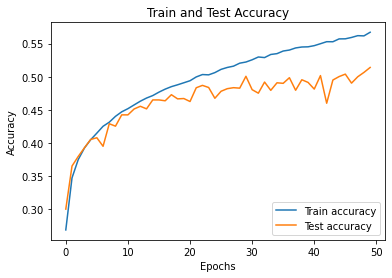

In [20]:
batch_size = 128
n_units = 128
epochs = 50
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = MLP(batch_size, n_units,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()
model1.plotAccuracy()

## CNN Class

In [11]:
class CNN:
    """
    batch_size
    n_units
    epochs
    activation
    nLabels
    loss
    inputSize # per element input size
    """    
    def __init__(self, batch_size, kernel_size, n_filter, epochs, activation, loss, xtrain, ytrain, xtest, ytest):
        self.__batchSize = batch_size
        self.__kernel_size = kernel_size
        self.__n_filter = n_filter
        self.__epochs = epochs
        self.__activation = activation
        self.__loss = loss
        self.__nLabels = len(yTrain[0])
        self.__inputSize = xTrain.shape[1:]
        self.__xTrain = xtrain
        self.__xTest = xtest
        self.__yTrain = ytrain
        self.__yTest = ytest
    
    def modelL(self):
        inputs = Input(shape=(self.__inputSize))
        x = BatchNormalization()(inputs)
        x = Conv2D(filters=self.__n_filter,
           kernel_size=self.__kernel_size,
           activation=self.__activation,
           padding='same')(x)
        x = MaxPooling2D()(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=self.__n_filter,
                   kernel_size=self.__kernel_size,
                   activation=self.__activation,
                   padding='same')(x)
        x = MaxPooling2D()(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=self.__n_filter,
                   kernel_size=self.__kernel_size,
                   activation=self.__activation,
                   padding='same')(x)
        x = Flatten()(x)
        x = BatchNormalization()(x)
        outputs = Dense(self.__nLabels, activation = 'softmax')(x)
        self.__model = Model(inputs=inputs, outputs=outputs, name = '4-Layer')
    
    def printModelSummary(self):
        self.__model.summary()
        
    def printModelPlot(self):
        plot_model(self.__model)
        
    def modelCompile(self):
        self.__model.compile(loss=self.__loss,
                             optimizer='sgd',
                             metrics=['accuracy'])
        
    def modelTrain(self):
        self.__history = self.__model.fit(self.__xTrain,
                                          self.__yTrain, 
                                          validation_data=(self.__xTest, self.__yTest), 
                                          epochs = self.__epochs,
                                          batch_size = self.__batchSize,
                                          verbose = False)
        
    def modelEvaluate(self):
        self.__lossValue, self.__acc = self.__model.evaluate(self.__xTest, 
                                                        self.__yTest, 
                                                        batch_size=self.__batchSize, 
                                                        verbose = False)
        
    def printAccuracy(self):
        print("\nTest accuracy: {:.1f}%".format((100.0 * self.__acc)))
        
    def plotCrossEntrophy(self):
        plt.plot(self.__history.history['loss'], label='Train loss')
        plt.plot(self.__history.history['val_loss'], label='Test loss')
        #plt.plot(history.history['val_acc'], label='Test accuracy')
        plt.title('Train and Test Loss')
        plt.ylabel('Cross-Entropy')
        plt.xlabel('Epochs')
        plt.legend(loc="upper right")
        plt.show()
        
    def plotAccuracy(self):
        plt.plot(self.__history.history['accuracy'], label='Train accuracy')
        plt.plot(self.__history.history['val_accuracy'], label='Test accuracy')
        plt.title('Train and Test Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(loc="lower right")
        plt.show()    
        
    def run(self):
        self.modelCompile()
        self.modelTrain()
        self.modelEvaluate()
        print(self)
        self.printAccuracy()
    
    def __str__(self):
        return inspect.cleandoc(f"""Model: {self.__model.name}
        Batch Size: {self.__batchSize}
        Kernel Size: {self.__kernel_size}
        Number of filters: {self.__n_filter}
        Epochs: {self.__epochs}
        Activation Function: {self.__activation}
        Loss Function: {self.__loss}""")
        
        

## Excuting different models for CNN
The hyperparameters for each model will be varied and each model will analyzed based on its accuracy

In [15]:
batch_size = 128
kernel_size = 3
filters = 32
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = CNN(batch_size, kernel_size, filters,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "4-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 32)          0   

In [13]:
batch_size = 128
kernel_size = 3
filters = 64
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = CNN(batch_size, kernel_size, filters,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "4-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0   

In [14]:
batch_size = 128
kernel_size = 3
filters = 128
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = CNN(batch_size, kernel_size, filters,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "4-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)         0   

In [17]:
batch_size = 64
kernel_size = 3
filters = 128
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = CNN(batch_size, kernel_size, filters,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "4-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 128)         0   

In [18]:
batch_size = 256
kernel_size = 3
filters = 128
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = CNN(batch_size, kernel_size, filters,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "4-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 128)         0   

In [21]:
batch_size = 128
kernel_size = 5
filters = 128
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = CNN(batch_size, kernel_size, filters,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "4-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 128)       9728      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)       409728    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 128)         0   

In [23]:
batch_size = 128
kernel_size = 7
filters = 128
epochs = 20
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = CNN(batch_size, kernel_size, filters,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "4-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 128)       18944     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 128)       802944    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 128)         0   

In [24]:
batch_size = 128
kernel_size = 5
filters = 128
epochs = 30
loss = 'categorical_crossentropy'
activation = 'relu'

model1 = CNN(batch_size, kernel_size, filters,
                    epochs, activation, loss, xTrain, yTrain, xTest, yTest)
model1.modelL()
model1.printModelSummary()
model1.run()

Model: "4-Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 128)       9728      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 128)       409728    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 128)         0   

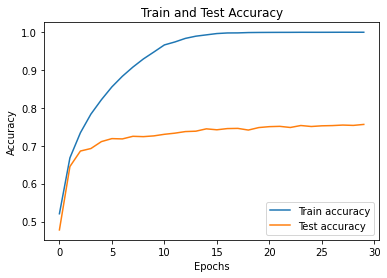

In [25]:
model1.plotAccuracy()

## Conclusion
I tried different ways to improve my models. Increasing the hidden units for the MLP help bringing the accuracy higher. The same with the numbers of filters the accuracy raises as the number of filter raises. I increase these hyper parameters by twice as much and the accuracy gain is around 1% to 2%.<br/>
After that I picked the model with the best accuracy, then I varied the batch size. I discovered that when varied, increase or decrease, my batch size the performance both decreased compared to the benchmark. Batch size of 128 was the sweet spot for me.<br/>
At around 30 epochs my models started to plateau for both CNN and MLP.<br/>
Increasing the kernel size also increases the performance of the CNN models.<br/>
My Best MLP is:<br/>
    -Model: 3-Layer<br/>
    -Batch Size: 128<br/>
    -Hidden Units: 128<br/>
    -Epochs: 50<br/>
    -Activation Function: relu<br/>
    -Loss Function: categorical_crossentropy<br/>
    -Test accuracy: 51.4%<br/>
My best CNN is:<br/>
    -Model: 4-Layer<br/>
    -Batch Size: 128<br/>
    -Kernel Size: 5<br/>
    -Number of filters: 128<br/>
    -Epochs: 30<br/>
    -Activation Function: relu<br/>
    -Loss Function: categorical_crossentropy<br/>
    -Test accuracy: 75.7%<br/>